In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /gdrive
/gdrive
Mounted at /content/drive


In [2]:
!pip install pascal-voc-tools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112 kB 22.8 MB/s 


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import time
import shutil
import torch.nn as nn
import torchvision
import cv2
# import pascal_voc_tools as PVT
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler
from torchvision import utils
from albumentations import (HorizontalFlip, ShiftScaleRotate, VerticalFlip, Normalize, Flip,
                            Compose, GaussNoise)
from torchvision.transforms import ToTensor
from albumentations.pytorch.transforms import ToTensorV2
from torchvision import transforms

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
#------------------ORIGINAL------------------------
# train_json = "/content/drive/My Drive/thyroid_nodule_detection/Experiment_3/dataset/train/resized_images.json"
# train_dir = "/content/drive/My Drive/thyroid_nodule_detection/Experiment_3/dataset/train/resized_images/"

# validation_json = "/content/drive/My Drive/thyroid_nodule_detection/Experiment_3/dataset/validation/resized_images.json"
# validation_dir = "/content/drive/My Drive/thyroid_nodule_detection/Experiment_3/dataset/validation/resized_images/"
#------------------ORIGINAL------------------------

#------------------FIXED LABELS------------------------
train_json = "/content/drive/My Drive/thyroid_nodule_detection/Freehand to Bounding Box Conversion Fix/fixed_labels/cropped_dataset/train/cropped_labels.json"
train_dir = "/content/drive/My Drive/thyroid_nodule_detection/Freehand to Bounding Box Conversion Fix/fixed_labels/cropped_dataset/train/cropped_images"

validation_json = "/content/drive/My Drive/thyroid_nodule_detection/Freehand to Bounding Box Conversion Fix/fixed_labels/cropped_dataset/validation/cropped_labels.json"
validation_dir = "/content/drive/My Drive/thyroid_nodule_detection/Freehand to Bounding Box Conversion Fix/fixed_labels/cropped_dataset/validation/cropped_images"
#------------------FIXED LABELS------------------------

temp_train_df = pd.read_json(train_json)
temp_validation_df = pd.read_json(validation_json)

print(f'shape of train dataframe is {temp_train_df.shape}')
print(f'shape of validation dataframe is {temp_validation_df.shape}')

shape of train dataframe is (322, 1)
shape of validation dataframe is (10, 1)


In [4]:
# classes = [
#     '__background__', '1', '2', '3', '4a', '4b', '4c', '5', '6' 
# ]
classes = [
    '__background__', '2', '3', '4', '5' 
]
num_classes = len(classes)

In [5]:
# def process_bbox(df):
#     cases = df
#     case_list = []
#     for case in cases:
#         temp_case = {}
#         temp_case['case_id'] = case['case_id']
#         temp_case['tirads'] = case['tirads']
#         temp_case['width'] = 560
#         temp_case['height'] = 360
#         temp_case['x'] = case['xmin'][0]
#         temp_case['y'] = case['ymin'][0]
#         temp_case['w'] = case['xmax'][0] - case['xmin'][0]
#         temp_case['h'] = case['ymax'][0] - case['ymin'][0]
#         case_list.append(temp_case)
#     return pd.DataFrame(case_list)
def process_bbox(df):
    cases = df
    case_list = []
    for case in cases:
        temp_case = {}
        temp_case['case_id'] = case['case_id']
        temp_case['tirads'] = case['labels']
        temp_case['width'] = 400 # should match cropped images
        temp_case['height'] = 350 # should match cropped images
        temp_case['x'] = case['bboxes'][0][0]
        temp_case['y'] = case['bboxes'][0][1]
        temp_case['w'] = case['bboxes'][0][2]
        if len(case['bboxes'][0]) < 4:
          temp_case['h'] = 1 # bounding box should have height which is greater than 0 if invalid to no break training
        else:
          temp_case['h'] = case['bboxes'][0][3]
        case_list.append(temp_case)
    return pd.DataFrame(case_list)


df_train = process_bbox(temp_train_df['cases'])
df_validation = process_bbox(temp_validation_df['cases'])
print(f'shape of dataframe after prerpocessing {df_train.shape}')
print(df_train.tail())

shape of dataframe after prerpocessing (322, 8)
    case_id  tirads  width  height      x     y      w      h
317   347_1     [3]    400     350  112.0  65.0  183.0  182.0
318   347_2     [3]    400     350   55.0  90.0  285.0  157.0
319   348_1  [4, 4]    400     350  250.0  74.0   68.0   84.0
320   350_2     [4]    400     350  109.0  32.0  184.0  146.0
321   350_1     [4]    400     350   89.0  24.0  275.0  162.0


In [6]:
import albumentations as A
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })
# define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })

In [7]:
class ThyroidNoduleDataset(Dataset):
    def __init__(self, data_frame, image_dir,classes,transforms=None, phase='train'):
        super().__init__()
        self.df = data_frame
        self.image_dir = image_dir
        self.images = data_frame['case_id'].unique()
        self.transforms = transforms
        self.classes = classes

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx] + '.jpg'
        #         image_arr = io.imread(os.path.join(self.image_dir,image))

        image_arr = cv2.imread(os.path.join(self.image_dir, image), cv2.IMREAD_COLOR)
        image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_arr /= 255.0

        image_id = str(image.split('.')[0])
        point = self.df[self.df['case_id'] == image_id]
        boxes = point[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)

        # there is only one class
        labels = []
        # for box in boxes: 
        #   labels.append(self.classes.index(self.df.get('tirads').get(idx)))

        for box in boxes: 
          labels.append(self.classes.index(str(round(self.df.get('tirads').get(idx)[0]))))
        
        
        labels = torch.as_tensor([lbl for lbl in labels])
        #labels = torch.as_tensor([lbl for lbl in self.df.get('tirads').get(idx)])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((point.shape[0],), dtype=torch.int64)

        target = {}
        target['bboxes'] = boxes
        target['labels'] = labels
        # target['image_id'] = torch.tensor(idx)
        # target['area'] = area
        # target['iscrowd'] = iscrowd

        if self.transforms:
            sample = {
                'image': image_arr,
                'bboxes': target['bboxes'],
                'labels': target['labels']
            }
            sample = self.transforms(**sample)
            image = sample['image']

        target['bboxes'] = torch.stack(tuple(map(torch.tensor,
                                                zip(*sample['bboxes'])))).permute(1, 0)
        target['boxes'] = target['bboxes'] # later the model needs the 'boxes' naming so keep this copy!

        return image, target, image_id

In [8]:
train_data = ThyroidNoduleDataset(df_train, train_dir,classes,get_train_transform(),  phase='train')
val_data = ThyroidNoduleDataset(df_validation, validation_dir,classes,get_valid_transform(), phase='validation')
print(f'Length of train data {len(train_data)}')
print(f'Length of validation data {len(val_data)}')

Length of train data 322
Length of validation data 10


In [9]:
print(train_data.__getitem__(3))
print(val_data.__getitem__(0))

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0471, 0.0000],
         [0.0235, 0.0157, 0.0118,  ..., 0.0000, 0.0039, 0.0000],
         [0.0118, 0.0000, 0.0000,  ..., 0.0196, 0.0000, 0.0275]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0471, 0.0000],
         [0.0235, 0.0157, 0.0118,  ..., 0.0000, 0.0039, 0.0000],
         [0.0118, 0.0000, 0.0000,  ..., 0.0196, 0.0000, 0.0275]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0

In [10]:
# batching
def collate_fn(batch):
    return tuple(zip(*batch))


train_data_loader = DataLoader(
    train_data,
    batch_size=5,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    val_data,
    batch_size=5,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [11]:
def image_convert(image):
    image = image.clone().cpu().numpy()
    image = image.transpose((1, 2, 0))
    image = (image * 255).astype(np.uint8)
    return image


def plot_img(data, idx):
    print(data)
    out = data.__getitem__(idx)
    image = image_convert(out[0])
    image = np.ascontiguousarray(image)
    bb = out[1]['bboxes'].numpy()
    for i in bb:
        cv2.rectangle(image, (int(i[0]), int(i[1])), (int(i[2]), int(i[3])), (0, 255, 0), thickness=2)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)


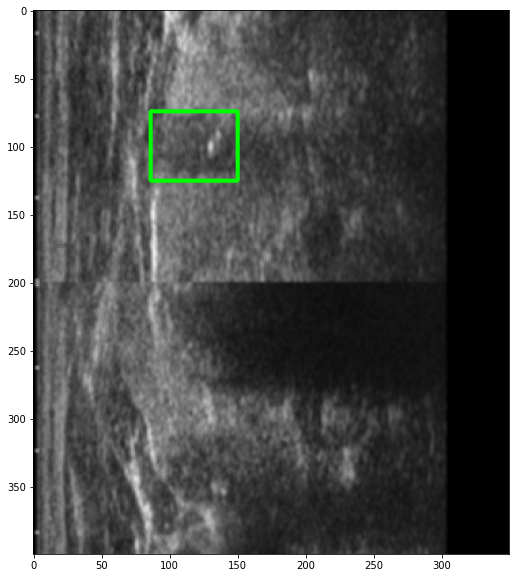

In [13]:
plot_img(train_data, 3)

In [14]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [15]:
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
print(in_features)

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
print(model.roi_heads.box_predictor )

1024
FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=5, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=20, bias=True)
)


usr/local/lib/python3.7/dist-packages/albumentations/core/bbox_utils.py/check_bbox
```
  bbox=list(bbox)
    for i in range(4):
      if bbox[i]<0:
        bbox[i]=0
      elif bbox[i]>1:
        bbox[i]=1
    bbox=tuple(bbox)
```

command + m + . = restart runtime



# New section

In [16]:
images, targets, ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

In [17]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# optimizer = torch.optim.Adam(params, lr=0.001)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [18]:
# helper functions to save best model

def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state: checkpoint we want to save
    is_best: is this the best checkpoint; min validation loss
    checkpoint_path: path to save checkpoint
    best_model_path: path to save best model
    """
    # save checkpoint data to the path given, checkpoint_path
    torch.save(state, checkpoint_path)
    # if it is a best model, min validation loss
    if is_best:
        # copy that checkpoint file to best path given, best_model_path
        shutil.copyfile(checkpoint_path, best_model_path)
        
def load_ckp(checkpoint_fpath, model, optimizer):
    """
    checkpoint_path: path to save checkpoint
    model: model that we want to load checkpoint parameters into       
    optimizer: optimizer we defined in previous training
    """
    # load check point
    checkpoint = torch.load(checkpoint_fpath)
    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['state_dict'])
    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer'])
    # initialize valid_loss_min from checkpoint to valid_loss_min
    valid_loss_min = checkpoint['valid_loss_min']
    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch'], valid_loss_min.item()

In [19]:
# torch.cuda.memory_summary(device=None, abbreviated=False)
torch.cuda.memory_summary(device=None)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  173336 KB |  173336 KB |  173336 KB |       0 B  |\n|       from large pool |  153600 KB |  153600 KB |  153600 KB |       0 B  |\n|       from small pool |   19736 KB |   19736 KB |   19736 KB |       0 B  |\n|---------------------------------------------------------------------------|\n| Active memory         |  173336 KB |  173336 KB |  173336 KB |       0 B  |\n|       from large pool |  153600 KB |  153600 KB |

In [21]:
num_epochs = 12
train_loss_min = 0.9
total_train_loss = []

checkpoint_path = "/content/drive/My Drive/thyroid_nodule_detection/Experiment_2 - TensorFlow/checkpoints/chkpoint_"
best_model_path = "/content/drive/My Drive/thyroid_nodule_detection/Experiment_2 - TensorFlow/checkpoints/bestmodel_may12.pt"

for epoch in range(num_epochs):
    print(f'Epoch :{epoch + 1}')
    start_time = time.time()
    train_loss = []
    model.train()
    for images, targets, image_ids in train_data_loader:
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        train_loss.append(losses.item())        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    #train_loss/len(train_data_loader.dataset)
    epoch_train_loss = np.mean(train_loss)
    total_train_loss.append(epoch_train_loss)
    print(f'Epoch train loss is {epoch_train_loss}')
    
#     if lr_scheduler is not None:
#         lr_scheduler.step()
    
    # create checkpoint variable and add important data
    checkpoint = {
            'epoch': epoch + 1,
            'train_loss_min': epoch_train_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
    
    # save checkpoint
    save_ckp(checkpoint, False, checkpoint_path, best_model_path)
    ## TODO: save the model if validation loss has decreased
    if epoch_train_loss <= train_loss_min:
            print('Train loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(train_loss_min,epoch_train_loss))
            # save checkpoint as best model
            save_ckp(checkpoint, True, checkpoint_path, best_model_path)
            train_loss_min = epoch_train_loss
    
    time_elapsed = time.time() - start_time
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Epoch :1
Epoch train loss is 0.26026035138225445
Train loss decreased (0.900000 --> 0.260260).  Saving model ...
0m 23s
Epoch :2
Epoch train loss is 0.24499183730944868
Train loss decreased (0.260260 --> 0.244992).  Saving model ...
0m 16s
Epoch :3
Epoch train loss is 0.2278689257737101
Train loss decreased (0.244992 --> 0.227869).  Saving model ...
0m 16s
Epoch :4
Epoch train loss is 0.21443574842588964
Train loss decreased (0.227869 --> 0.214436).  Saving model ...
0m 16s
Epoch :5
Epoch train loss is 0.2061914181279237
Train loss decreased (0.214436 --> 0.206191).  Saving model ...
0m 16s
Epoch :6
Epoch train loss is 0.20401580722880977
Train loss decreased (0.206191 --> 0.204016).  Saving model ...
0m 16s
Epoch :7
Epoch train loss is 0.19340618922956276
Train loss decreased (0.204016 --> 0.193406).  Saving model ...
0m 19s
Epoch :8
Epoch train loss is 0.1788861096913578
Train loss decreased (0.193406 --> 0.178886).  Saving model ...
0m 16s
Epoch :9
Epoch train loss is 0.181544962065

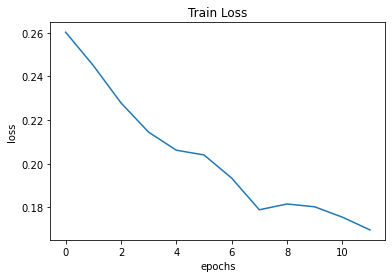

In [22]:
plt.title('Train Loss')
plt.plot(total_train_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [29]:
import glob as glob
checkpoint = torch.load('/content/drive/My Drive/thyroid_nodule_detection/Experiment_2 - TensorFlow/checkpoints/chkpoint_')
model.load_state_dict(torch.load('/content/drive/My Drive/thyroid_nodule_detection/Experiment_2 - TensorFlow/checkpoints/bestmodel_may12.pt'), False)
# model.load_state_dict('/content/drive/My Drive/thyroid_nodule_detection/Experiment_2 - TensorFlow/checkpoints/chkpoint_')
model.to(device).eval()
# directory where all the images are present
DIR_TEST = '/content/drive/My Drive/thyroid_nodule_detection/dataset/test/'
test_images = glob.glob(f"{DIR_TEST}/*.jpg")
print(f"Test instances: {len(test_images)}")
# define the detection threshold...
# ... any detection having score below this will be discarded
# detection_threshold = 0.075
detection_threshold = 0.45
# to count the total number of images iterated through
frame_count = 0
# to keep adding the FPS for each image
total_fps = 0

Test instances: 10


In [24]:
# this will help to create a different color for each class
COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

In [25]:
print(test_images)

['/content/drive/My Drive/thyroid_nodule_detection/dataset/test/384_1.jpg', '/content/drive/My Drive/thyroid_nodule_detection/dataset/test/382_1.jpg', '/content/drive/My Drive/thyroid_nodule_detection/dataset/test/381_1.jpg', '/content/drive/My Drive/thyroid_nodule_detection/dataset/test/390_1.jpg', '/content/drive/My Drive/thyroid_nodule_detection/dataset/test/386_1.jpg', '/content/drive/My Drive/thyroid_nodule_detection/dataset/test/381_2.jpg', '/content/drive/My Drive/thyroid_nodule_detection/dataset/test/387_1.jpg', '/content/drive/My Drive/thyroid_nodule_detection/dataset/test/383_1.jpg', '/content/drive/My Drive/thyroid_nodule_detection/dataset/test/380_1.jpg', '/content/drive/My Drive/thyroid_nodule_detection/dataset/test/387_2.jpg']


box
[224 123 316 188]
class
4


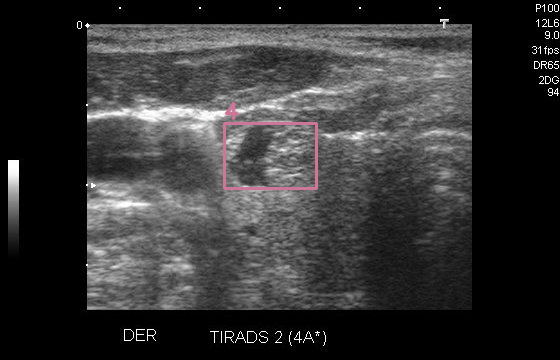

Image 1 done...
[0.59951    0.17865077 0.13460164 0.10017475 0.08903446 0.07122177
 0.05954563 0.05743159 0.0510729 ]
--------------------------------------------------
box
[167  39 387 206]
class
4
box
[245 102 309 146]
class
4


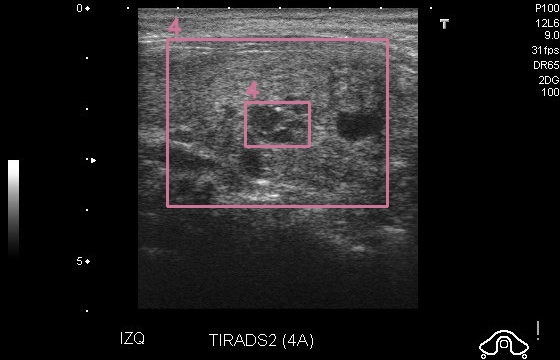

Image 2 done...
[0.5284612  0.4642679  0.25078458 0.2333449  0.15728436 0.11588463
 0.11521643 0.10284452 0.09897284 0.09266186 0.07870299 0.06097401
 0.05760132]
--------------------------------------------------
box
[234 117 324 199]
class
4
box
[168  59 431 216]
class
4


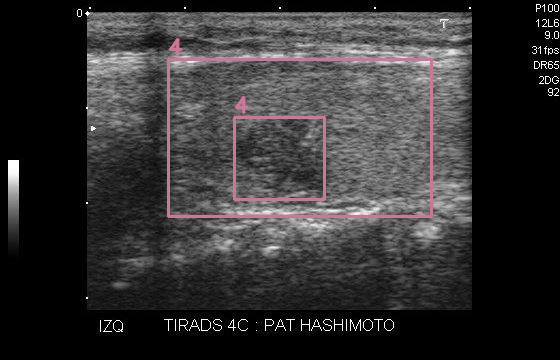

Image 3 done...
[0.72563434 0.49365813 0.26863092 0.25294673 0.22600348 0.16515578
 0.16371767 0.141273   0.10979766 0.10606542 0.09413145 0.0924397
 0.08431377 0.08385967 0.07562972 0.07256203 0.06802219 0.06055934]
--------------------------------------------------
box
[212  99 321 175]
class
4


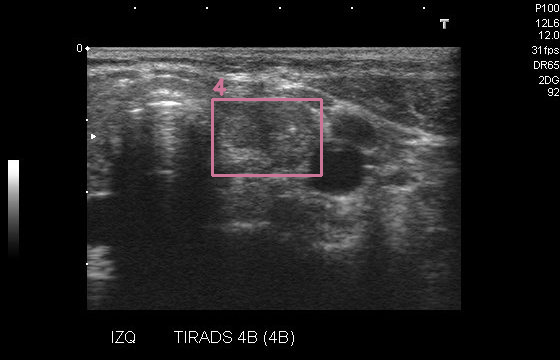

Image 4 done...
[0.6740524  0.17549816 0.11824308 0.11359996 0.0905431  0.05329301
 0.05327537]
--------------------------------------------------
box
[154  59 269 182]
class
4


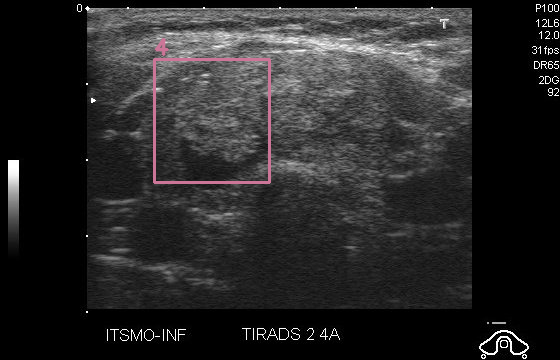

Image 5 done...
[0.4864265  0.42660478 0.4103827  0.3406699  0.25322217 0.24203914
 0.20196347 0.19432445 0.17647438 0.16577074 0.16029431 0.12829758
 0.12072177 0.10887609 0.10194337 0.09549943 0.08853084 0.07765335
 0.0759167  0.07112808 0.07088666 0.06869306 0.06653928]
--------------------------------------------------


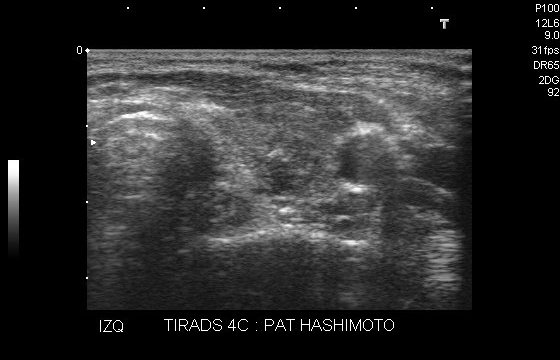

Image 6 done...
[0.4267146  0.4027922  0.3524715  0.22669213 0.19299814 0.18821876
 0.16126615 0.15566443 0.13498199 0.1271444  0.10843164 0.0987936
 0.07568583 0.0662701  0.06362259 0.06056954 0.05846706 0.05365667]
--------------------------------------------------


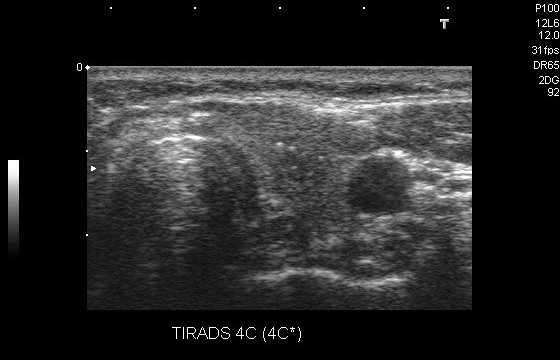

Image 7 done...
[0.28051385 0.24442641 0.17373684 0.13926789 0.125363   0.12154604
 0.10574558 0.09570571 0.08351405 0.05924719 0.05633726 0.0551806
 0.0525407 ]
--------------------------------------------------
box
[284  37 370 115]
class
4
box
[222  67 291 136]
class
4


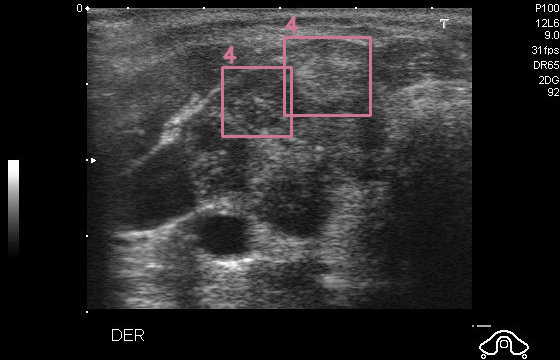

Image 8 done...
[0.59546286 0.46225587 0.4133327  0.38533992 0.374808   0.19918524
 0.19475222 0.17836115 0.16129507 0.15921767 0.15917729 0.14015496
 0.11161915 0.11079324 0.0979035  0.09282442 0.09019234 0.08880817
 0.07035469 0.06791508 0.05927868 0.05538576 0.05146858 0.05002051]
--------------------------------------------------
box
[130  64 284 185]
class
4
box
[266  59 444 238]
class
4
box
[116  52 319 236]
class
4


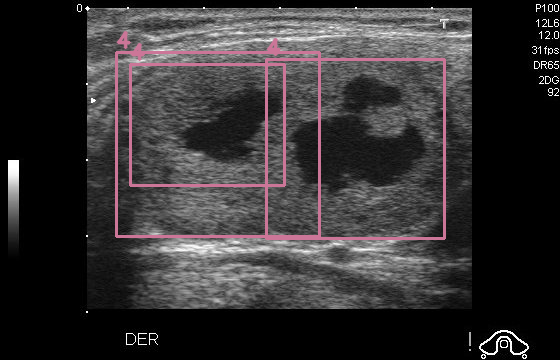

Image 9 done...
[0.507038   0.47424796 0.4578525  0.34304994 0.29830006 0.25461468
 0.19720124 0.19422184 0.17056756 0.1701026  0.14975211 0.1437077
 0.10668273 0.10589759 0.09936968 0.09131533 0.09011947 0.08540104
 0.07410148 0.06916726 0.05931763 0.05201952]
--------------------------------------------------
box
[236 125 305 185]
class
4


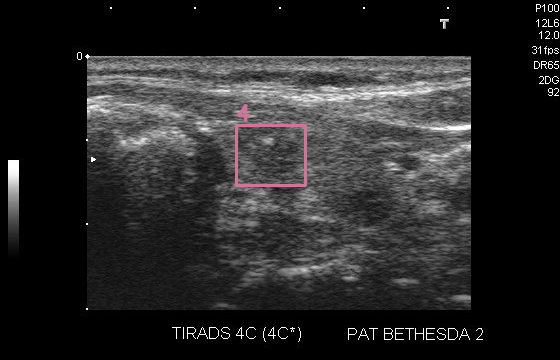

Image 10 done...
[0.4942114  0.21094057 0.17786661 0.13979664 0.13733502 0.10926874
 0.0911047  0.0793504  0.07613363 0.06946759 0.06596454 0.06513619
 0.06127411 0.05163263]
--------------------------------------------------
TEST PREDICTIONS COMPLETE
Average FPS: 29.671


In [30]:
from google.colab.patches import cv2_imshow
# for i in range(len(test_images)):
for i in range(len(test_images)):
    # get the image file name for saving output later on
    image_name = test_images[1].split(os.path.sep)[-1].split('.')[0]
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    # BGR to RGB
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(np.float32)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float).cuda()
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    start_time = time.time()
    with torch.no_grad():
        outputs = model(image.to(device))
    end_time = time.time()

    # get the current fps
    fps = 1 / (end_time - start_time)
    # add `fps` to `total_fps`
    total_fps += fps
    # increment frame count
    frame_count += 1
    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        # get all the predicited class names
        pred_classes = [classes[i] for i in outputs[0]['labels'].cpu().numpy()]
        
        # draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(draw_boxes):
            print('box')
            print(box)
            class_name = pred_classes[j]
            print('class')
            print(class_name)
            color = COLORS[classes.index(class_name)]
            cv2.rectangle(orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        color, 2)
            cv2.putText(orig_image, class_name, 
                        (int(box[0]), int(box[1]-5)),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 
                        2, lineType=cv2.LINE_AA)

        cv2_imshow(orig_image)
        cv2.waitKey(1)
        cv2.imwrite(f"/content/drive/My Drive/thyroid_nodule_detection/Experiment_2 - TensorFlow/inference_outputs/images/{image_name}.jpg", orig_image)
    print(f"Image {i+1} done...")
    print(scores)
    
    print('-'*50)

print('TEST PREDICTIONS COMPLETE')
cv2.destroyAllWindows()
# calculate and print the average FPS
avg_fps = total_fps / frame_count
print(f"Average FPS: {avg_fps:.3f}")

In [ ]:
# def get_transforms(phase):
#     list_transforms = []
#     if phase == 'train':
#         list_transforms.extend([
#             Flip(p=0.5)
#         ])
#     list_transforms.extend(
#         [
#             ToTensorV2(),
#         ])
#     list_trfms = Compose(list_transforms,
#                          bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
#     return list_trfms


# class ThyroidNoduleDataset(Dataset):
#     def __init__(self, data_frame, image_dir, phase='train'):
#         super().__init__()
#         self.df = data_frame
#         self.image_dir = image_dir
#         self.images = data_frame['case_id'].unique()
#         self.transforms = get_transforms(phase)

#     def __len__(self):
#         return len(self.images)

#     def __getitem__(self, idx):
#         image = self.images[idx] + '.jpg'
#         #         image_arr = io.imread(os.path.join(self.image_dir,image))

#         image_arr = cv2.imread(os.path.join(self.image_dir, image), cv2.IMREAD_COLOR)
#         image_arr = cv2.cvtColor(image_arr, cv2.COLOR_BGR2RGB).astype(np.float32)
#         image_arr /= 255.0
#         image_id = str(image.split('.')[0])
#         point = self.df[self.df['case_id'] == image_id]
#         boxes = point[['x', 'y', 'w', 'h']].values
#         boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
#         boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

#         area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
#         area = torch.as_tensor(area, dtype=torch.float32)

#         # there is only one class
#         labels = torch.ones((point.shape[0],), dtype=torch.int64)

#         # suppose all instances are not crowd
#         iscrowd = torch.zeros((point.shape[0],), dtype=torch.int64)

#         target = {}
#         target['boxes'] = boxes
#         target['labels'] = labels
#         target['image_id'] = torch.tensor(idx)
#         target['area'] = area
#         target['iscrowd'] = iscrowd

#         if self.transforms:
#             sample = {
#                 'image': image_arr,
#                 'bboxes': target['boxes'],
#                 'labels': target['labels']
#             }
#             sample = self.transforms(**sample)
#             image = sample['image']

#         target['boxes'] = torch.stack(tuple(map(torch.tensor,
#                                                 zip(*sample['bboxes'])))).permute(1, 0)

#         return image, target, image_id
